# SWMM experiment procedure

## Steps
0. Calibrate tank and pipe sensors

1. Run an impulse through the system

2. Load impulse into SWMM as inflow hydrograph

3. Compare SWMM pipe depth with measured pipe depth

In [2]:
# Library imports.
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.signal import correlate

# UrbanSurge imports.
from urbansurge.swmm_model import SWMM
from urbansurge.data_acquisition import align_measurements, voltage_to_value
from urbansurge.fault_diagnosis.moment_detection import moment_fault_detect

%load_ext autoreload
%autoreload 2 

## Sensor Parameters

In [3]:
sensor_parameters = {
    'Sergei': {
        'calibration': {
            'b0': 0.3664,
            'b1': 0.7555
        },
        'location': 'pipe',
    },
    'Louise': {
        'calibration': {
            'b0': 0.3208,
            'b1': 0.7624
        },
        'location': 'pipe',
    },
    'Ludwig': {
        'calibration': {
            'b0': 0.4141,
            'b1': 0.774
        },
        'location': 'pipe',
    },
    'Tank': {
        'calibration': {
            'b0': 4.3401,
            'b1': 2.3017
        },
        'location': 'tank',
    },
}

## Load in experiment

#### Baseline and test experiments

In [4]:
# Load in experiment data.
experiment_dir = Path(r"C:\Users\ay434\Box\Research\Smart_Stormwater\DeFrees Lab System\Experiments\2025-01-09")

# List file names for easy copy-paste.
for fp in experiment_dir.glob('*.csv'):
    print(f'"{fp.name}",')

# Baseline files.
baseline_files = [
    "2025-01-09_14-45-38_sensor_data.csv",
    "2025-01-09_14-47-22_sensor_data.csv",
    "2025-01-09_14-48-08_sensor_data.csv",
    "2025-01-09_14-48-52_sensor_data.csv",
    "2025-01-09_14-49-35_sensor_data.csv",
]

# Test files.
test_files = [
    "2025-01-09_14-51-51_sensor_data.csv",
    "2025-01-09_14-52-38_sensor_data.csv",
    "2025-01-09_14-53-24_sensor_data.csv",
]

# Baseline data frames.
baseline_dfs = [pd.read_csv(experiment_dir / f) for f in baseline_files]

# Test data frames.
test_dfs = [pd.read_csv(experiment_dir / f) for f in test_files]

"2025-01-09_14-45-38_sensor_data.csv",
"2025-01-09_14-47-22_sensor_data.csv",
"2025-01-09_14-48-08_sensor_data.csv",
"2025-01-09_14-48-52_sensor_data.csv",
"2025-01-09_14-49-35_sensor_data.csv",
"2025-01-09_14-51-51_sensor_data.csv",
"2025-01-09_14-52-38_sensor_data.csv",
"2025-01-09_14-53-24_sensor_data.csv",


#### Plot sensor readings

Text(0, 0.5, 'Voltage')

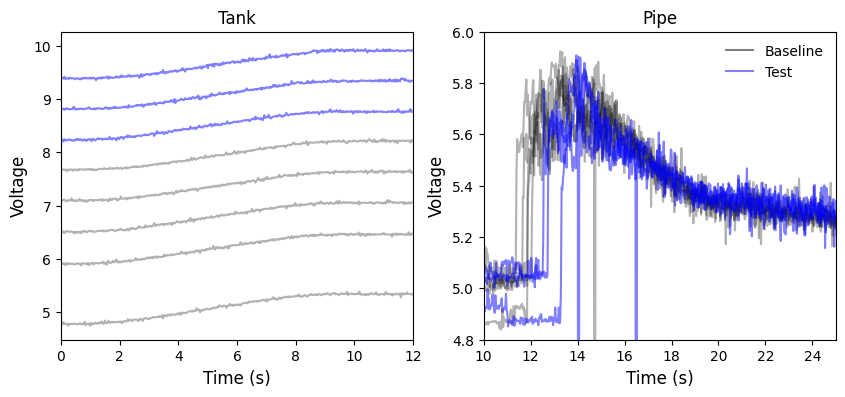

In [24]:
# Unaligned impulse and depth measurements.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Impulse.
for df in baseline_dfs:
    ax1.plot(df['time'], df['V_ai0'], 'k', alpha=0.3)

for df in test_dfs:
    ax1.plot(df['time'], df['V_ai0'], 'b', alpha=0.5)

ax1.set_xlim(0, 12)
ax1.set_title('Tank')
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Voltage', fontsize=12)

# Depth in pipe.
for df in baseline_dfs:
    ax2.plot(df['time'], df['V_ai1'], 'k', alpha=0.3)

for df in test_dfs:
    ax2.plot(df['time'], df['V_ai1'], 'b', alpha=0.5)

# Legend plots.
ax2.plot([], [], 'k', alpha=0.5, label='Baseline')
ax2.plot([], [], 'b', alpha=0.5, label='Test')
ax2.legend(fontsize=10, frameon=False)

ax2.set_xlim(10, 25)
ax2.set_ylim(4.8, 6)
ax2.set_title('Pipe')
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Voltage', fontsize=12)


#### Convert voltage to depth (tank)

In [6]:
# Tank measurements.
tank_sensor_name = 'Tank'
b0_tank = sensor_parameters[tank_sensor_name]['calibration']['b0']
b1_tank = sensor_parameters[tank_sensor_name]['calibration']['b1']

# Baseline data frames.
for df in baseline_dfs:
    # Tank voltage.
    V_tank = df['V_ai0'].to_numpy()

    # Tank height (cm).
    h_tank = voltage_to_value(V_tank, b0_tank, b1_tank)

    # Add new column to df with converted values.
    df['V_ai0_h'] = h_tank

# Test data frames.
for df in test_dfs:
    # Tank voltage.
    V_tank = df['V_ai0'].to_numpy()

    # Tank height (cm).
    h_tank = voltage_to_value(V_tank, b0_tank, b1_tank)

    # Add new column to df with converted values.
    df['V_ai0_h'] = h_tank

#### Convert voltage to depth (pipe)

In [11]:
# Pipe measurements.
pipe_sensor_name = 'Sergei'
b0 = sensor_parameters[pipe_sensor_name]['calibration']['b0']
b1 = sensor_parameters[pipe_sensor_name]['calibration']['b1']

# Baseline data frames.
for df in baseline_dfs:
    # Voltage.
    V = df['V_ai1'].to_numpy()

    # Depth (cm).
    d = voltage_to_value(V, b0, b1)

    # Add new column to df with converted values.
    df['V_ai1_d'] = d

# Test data frames.
for df in test_dfs:
    # Voltage.
    V = df['V_ai1'].to_numpy()

    # Depth (cm).
    d = voltage_to_value(V, b0, b1)

    # Add new column to df with converted values.
    df['V_ai1_d'] = d

#### Zero out starting tank levels

Text(0, 0.5, 'Water Level (cm)')

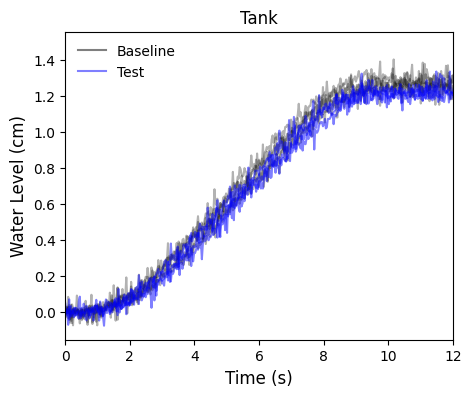

In [22]:
# Number of starting indices where tank is at "zero."
n_init = 20

# Baseline data frames.
for df in baseline_dfs:
    # Starting value is mean of first n_init values.
    V_init = df['V_ai0_h'].iloc[:n_init].mean()
    
    # Subtract out the initial voltage.
    V_zeroed = df['V_ai0_h'] - V_init

    # Substitute into new data frame.
    df['V_ai0_h_zero'] = V_zeroed

# Test data frames.
for df in test_dfs:
    # Starting value is mean of first n_init values.
    V_init = df['V_ai0_h'].iloc[:n_init].mean()
    
    # Subtract out the initial voltage.
    V_zeroed = df['V_ai0_h'] - V_init

    # Substitute into new data frame.
    df['V_ai0_h_zero'] = V_zeroed

# Plot.
fig, ax1 = plt.subplots(figsize=(5,4))

# Impulse.
for df in baseline_dfs:
    ax1.plot(df['time'], df['V_ai0_h_zero'], 'k', alpha=0.3)

for df in test_dfs:
    ax1.plot(df['time'], df['V_ai0_h_zero'], 'b', alpha=0.5)

# Legend plots.
ax1.plot([], [], 'k', alpha=0.5, label='Baseline')
ax1.plot([], [], 'b', alpha=0.5, label='Test')
ax1.legend(fontsize=10, frameon=False)

ax1.set_xlim(0, 12)
ax1.set_title('Tank')
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Water Level (cm)', fontsize=12)

#### Align sensor readings based on head tank measurements.

Text(0, 0.5, 'Depth (cm)')

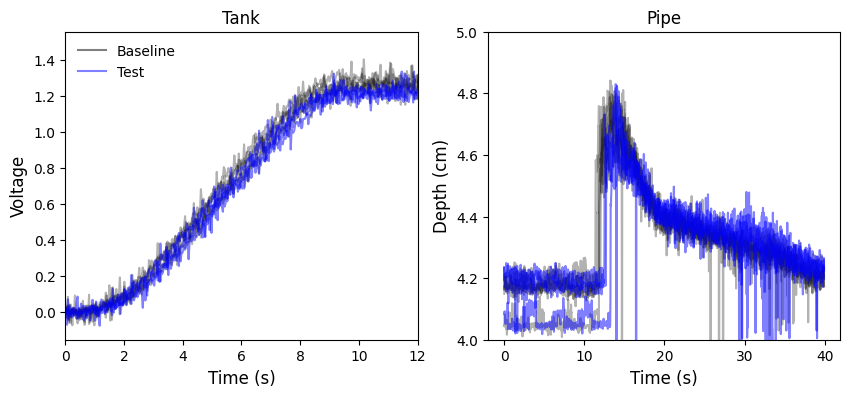

In [20]:
# Align all data frames to reference data frame based on head tank measurement column.

# Reference data frame.
df_ref = baseline_dfs[0]
df_ref['time_align'] = df_ref['time'] # This is the reference data frame so it doesn't need to be aligned.

# Align baseline data frames.
for df in baseline_dfs[1:]:
    t_align = align_measurements(df_ref, df, 'time', 'V_ai0_h_zero')
    df['time_align'] = t_align

# Align test data frames.
for df in test_dfs:
    t_align = align_measurements(df_ref, df, 'time', 'V_ai0_h_zero')
    df['time_align'] = t_align

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Impulse.
for df in baseline_dfs:
    ax1.plot(df['time_align'], df['V_ai0_h_zero'], 'k', alpha=0.3)

for df in test_dfs:
    ax1.plot(df['time_align'], df['V_ai0_h_zero'], 'b', alpha=0.5)

# Legend plots.
ax1.plot([], [], 'k', alpha=0.5, label='Baseline')
ax1.plot([], [], 'b', alpha=0.5, label='Test')
ax1.legend(fontsize=10, frameon=False)

ax1.set_xlim(0, 12)
ax1.set_title('Tank')
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Voltage', fontsize=12)

# Depth in pipe.
for df in baseline_dfs:
    ax2.plot(df['time_align'], df['V_ai1_d'], 'k', alpha=0.3)

for df in test_dfs:
    ax2.plot(df['time_align'], df['V_ai1_d'], 'b', alpha=0.5)

# ax2.set_xlim(10, 25)
ax2.set_ylim(4, 5)
ax2.set_title('Pipe')
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Depth (cm)', fontsize=12)

## Impulse

### Process raw tank measurement to flow.

### Convert to SWMM-readable impulse

## Depth measurements

## SWMM simulation

### Load SWMM modeled depth

In [2]:
# Path to configuration file.
config_path = r"lab_system_config.yml"

# Create instance of SWMM model.
swmm = SWMM(config_path)

# Configure model.
swmm.configure_model()

# Extract depth at measurement link.


Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-01 06:00:00


## Compare measured and modeled depths

### Fault Detection

In [25]:
# Number of sensors.
n_sensor = 1

# Number of time steps.
Nt = baseline_dfs[0].shape[0] # Number of baseline time steps.

# Time steps.
dt = baseline_dfs[0]['time'][1] - baseline_dfs[0]['time'][0]
dts = [datetime.now() + timedelta(seconds=i*dt) for i in range(Nt)]

# Format baseline samples.
n_samp_base = len(baseline_dfs)
y_base = np.zeros((n_samp_base, Nt, 1))
for i, df in enumerate(baseline_dfs):
    y_base[i,:,:] = df['V_ai1_d'].to_numpy().reshape(-1,1)

# Format observation samples.
n_samp_test = len(test_dfs)
detections = []
moment_dicts = []
for i, df in enumerate(test_dfs):
    y_test = df['V_ai1_d'].to_numpy().reshape(1,-1)
    detect, moments = moment_fault_detect(dts, y_base, y_test, return_moments=True)
    detections.append(detect)
    moment_dicts.append(moments)

print(f'Detections: {detections}')

Detections: [False, False, False]


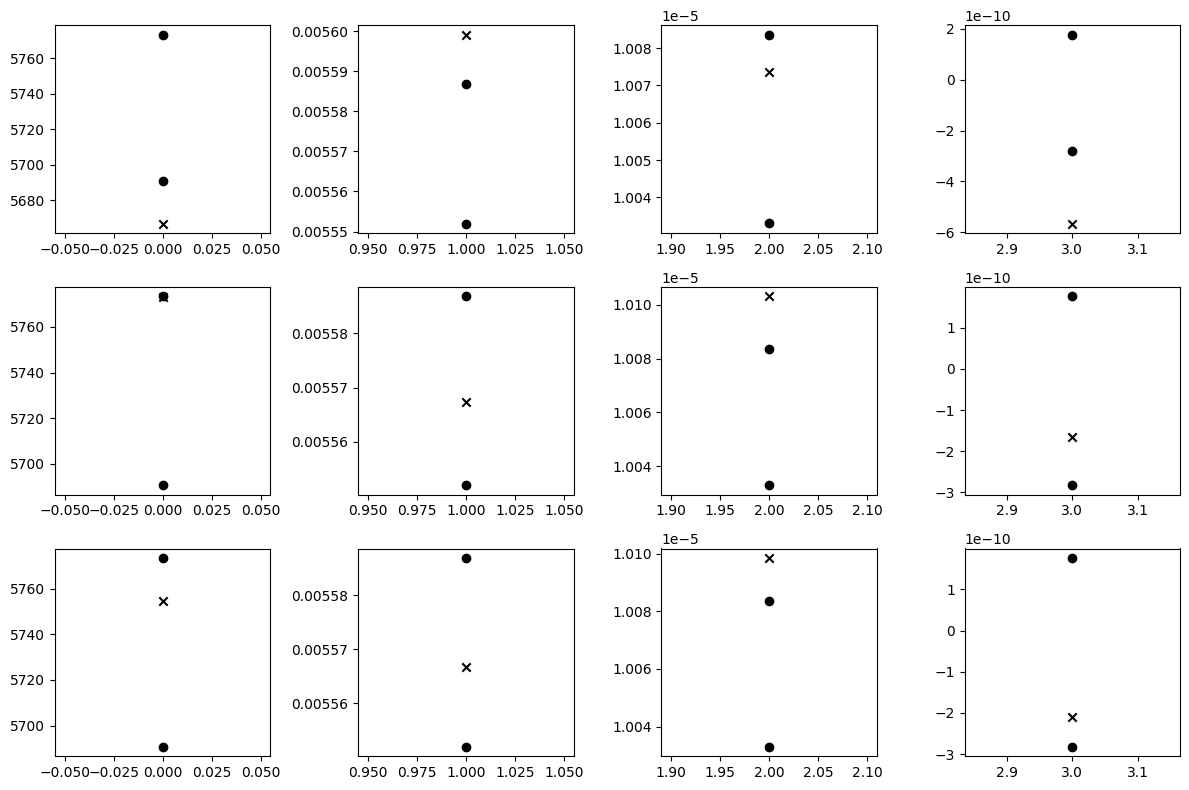

In [26]:
fig, axes = plt.subplots(3,4, figsize=(12,8))
for i in range(len(moment_dicts)):
    baseline_moments = moment_dicts[i]['baseline']
    test_moments = moment_dicts[i]['observation']

    for j in range(4):
        axes[i,j].scatter(j, np.min(baseline_moments[:,j]), c='k')
        axes[i,j].scatter(j, np.max(baseline_moments[:,j]), c='k')
        axes[i,j].scatter(j, test_moments[j], c='k', marker='x')

fig.tight_layout()

### Fault Diagnosis